# Анализ лояльности пользователей Яндекс Афиши с помощью Python

- Автор: Молчанов Никита (*можно обращаться на "ты"*)
- Дата: 03.12.2025

### Цели и задачи проекта
---
#### <font color='black'>Цель проекта:</font><br>
<font color='black'>Анализ поведения пользователей для выявления перспективных клиентов, более точной настройки рекламы, оптимизации бюджета и повышения уровня лояльности.</font><br>
<br>
#### <font color='black'>Задачи:
- Выгрузка данных с помощью подключения к базе данных и формирования датасета с помощью запроса sql;
- Предобработка данных. Приведение данных к единой валюте. Анализ пропусков, нормализация данных(при необходимости);
- Проверка распределения численных значений и их выбросов. Визуализация и промежуточный вывод;
- Создание профиля пользователя. Добавление бинарных признаков по заказам;
- Расчёт статистических показателей по профилю пользователей;
- Исследовательский анализ данных(распределение пользователей по признакам, сегментация пользователей, оценка равномерности распределения пользователей по сегментам);
- Проверка продуктовых гипотез;
- Исследование поведения пользователей через показатели вырочки и составва заказов;
- Исследование временых характеристик первого заказа и их влияния на повторные покупки;
- Корреляционный анализ покупок и признаков пользователей;
- Формирование общего вывода;
- Публикация поекта на GitHub(или GitLab)

</font>

### Содержимое проекта
---
- [Цели и задачи проекта](#цели-и-задачи-проекта)
- [Шаг 1. Загрузка данных и их предобработка](#1-шаг-1-загрузка-данных-и-их-предобработка)
- [Шаг 2. Предобработка данных](#2-шаг-2-предобработка-данных)
- [Шаг 3. Создание профиля пользователя](#2-шаг-3-создание-профиля-пользователя)
- [Шаг 4. Исследовательский анализ данных](#шаг-4-исследовательский-анализ-данных)
- [Шаг 5. Общие выводы и рекомендации](#шаг-5-общие-выводы-и-рекомендации)
---

## 1. Шаг 1. Загрузка данных и их предобработка
---

In [ ]:
%pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install phik -U

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Подгрузим библиотеки, которые нам понадобятся
import pandas as pd
import numpy as np
# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
# Для определения корреляции (Шаг 3, пункт 6)
from phik import phik_matrix
from sqlalchemy import create_engine

In [ ]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             } 

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)

In [ ]:
query = '''
SELECT p.user_id
      ,p.device_type_canonical
      ,p.order_id
      ,p.created_dt_msk AS order_dt
      ,p.created_ts_msk AS order_ts
      ,p.currency_code
      ,p.revenue
      ,p.tickets_count
      ,p.created_dt_msk::date - LAG(p.created_dt_msk::date) 
      OVER(PARTITION BY user_id ORDER BY p.created_dt_msk) AS days_since_prev
      ,e.event_id
      ,e.event_name_code AS event_name
      ,e.event_type_main
      ,p.service_name
      ,r.region_name
      ,c.city_name
FROM afisha.purchases as p
INNER JOIN afisha.events e USING (event_id)
INNER JOIN afisha.city c USING (city_id)
INNER JOIN afisha.regions r USING (region_id)
WHERE p.device_type_canonical IN ('mobile', 'desktop')
AND e.event_type_main != 'фильм'
ORDER BY user_id
'''

In [ ]:
df = pd.read_sql_query(query, con=engine)
df.head(10)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19.0,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16.0,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,NaN,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

**Промежуточный по первичному знакомсву с данными `afisha`:**<br>
- Датасет содержит 290611 строк и 15 столбцов;
- Типы данных корректные на первый взгляд(можно поле `ticket_count` соптимизировать по типу);
- Пропуски присутствуют только в поле `days_since_prev`, у пользователей, которые сделали только один заказ. Количество этих пользователей `21933`; 

In [ ]:
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')
df.dtypes # Проверяем, соптимизировали ли тип данных

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                      int8
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object

Тип данных у поля `ticket_count` сделан более оптимальным - `int8`. У полей `order_id` и `event_id` типы оптимизировать не целесообразно, так как БД может расширяться в будущем.

## 2. Шаг 2. Предобработка данных
---

Задача 2.1. Пересчет тенге в рубли.

In [ ]:
df_currency = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
df_currency.head(10)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
5,2024-01-15,100,19.4501,kzt
6,2024-01-16,100,19.4264,kzt
7,2024-01-17,100,19.4177,kzt
8,2024-01-18,100,19.5798,kzt
9,2024-01-19,100,19.5741,kzt


In [ ]:
df_currency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Нужно привести выручку к единой валюте. Предлагаются следующие шаги:
- Приведем поле `data` к формату даты
- Соединим датафреймы по дате, чтобы получить правильный курс на конкретный день.
- Для курса в тенге пересчитаем в рудли по формуле *revenue_rub = revenue * curs / nominal*


In [ ]:
# Преобразуем тип у поля data
df_currency['data'] = pd.to_datetime(df_currency['data'])
# Соединияем  датафрейме по дате
df_merge_currency = df.merge(df_currency[['data', 'nominal', 'curs']], left_on='order_dt', right_on='data', how='left')

In [ ]:
# Проверяем(выводим строки в тенге, чтобы потом проверить, получился ли пересчет)
df_merge_currency[df_merge_currency['currency_code']=='kzt'].head(10)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-17,100,19.0125
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-02,100,18.9330
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-09,100,18.5991
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,2024-06-11,100,19.8928
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-04,100,19.9833
461,01370a0e9c1a7d5,mobile,2229724,2024-06-04,2024-06-04 13:25:28,kzt,7397.66,4,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-04,100,19.9833
462,01370a0e9c1a7d5,mobile,2229753,2024-06-04,2024-06-04 13:26:32,kzt,5548.24,3,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-04,100,19.9833
463,01370a0e9c1a7d5,mobile,2229782,2024-06-04,2024-06-04 13:17:35,kzt,3698.83,2,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-04,100,19.9833
464,01370a0e9c1a7d5,desktop,5227657,2024-06-04,2024-06-04 13:28:17,kzt,7397.66,4,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-04,100,19.9833
515,01370a0e9c1a7d5,mobile,2044298,2024-09-05,2024-09-05 16:15:58,kzt,361.08,4,1.0,561747,27956246-d4a5-4b76-b5db-719831c41591,другое,Мой билет,Шанырский регион,Синеводск,2024-09-05,100,18.4217


In [ ]:
#Пересчитываем выручку из тенге в рубли, где это требуется
df['revenue_rub'] = df_merge_currency.apply(
    lambda row: row['revenue'] if row['currency_code']=='rub'
    else row['revenue'] * row['curs'] / row['nominal'], axis=1
)

In [ ]:
# Проверяем, получился ли пересчет
df[df['currency_code']=='kzt'].head(10)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591
461,01370a0e9c1a7d5,mobile,2229724,2024-06-04,2024-06-04 13:25:28,kzt,7397.66,4,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591
462,01370a0e9c1a7d5,mobile,2229753,2024-06-04,2024-06-04 13:26:32,kzt,5548.24,3,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1108.721444
463,01370a0e9c1a7d5,mobile,2229782,2024-06-04,2024-06-04 13:17:35,kzt,3698.83,2,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,739.148295
464,01370a0e9c1a7d5,desktop,5227657,2024-06-04,2024-06-04 13:28:17,kzt,7397.66,4,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591
515,01370a0e9c1a7d5,mobile,2044298,2024-09-05,2024-09-05 16:15:58,kzt,361.08,4,1.0,561747,27956246-d4a5-4b76-b5db-719831c41591,другое,Мой билет,Шанырский регион,Синеводск,66.517074


In [ ]:
df.info() #еще раз подгружаем информацию о получившимся датасете с полем revenue_rub

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Пропуски присутствуют только в поле days_since_prev

Задача 2.2. Проверка данных. Нормализация. Изучение категориальных значений. Изучения распределение числовых данных, визуализация и оценка выбросов.

In [ ]:
'''Делаем копию датафрейма перед предобработкой'''
df_original = df.copy()
orig_row_size = len(df_original) # размер изначального для последующего контроля
orig_row_size

290611

In [ ]:
cat_cols = [
    'device_type_canonical',
    'currency_code',
    'event_name',
    'event_type_main',
    'service_name',
    'region_name', 
    'city_name'
] # список из категориальных столбцов
keep_case_cols = ['event_name', 'region_name', 'city_name'] # список столбцов, где важно сохранить регистр, так как это названия городов, т.е нормализацию применять не следует

In [ ]:
'''Проведем нормальзацию данных'''
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip() # удаляем пробелы в конце и начале
    if col not in keep_case_cols:
        df[col] = df[col].str.lower()
df.head(15)        


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,за билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,билеты без проблем,Озернинский край,Родниковецк,1390.41
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19.0,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,облачко,Лугоградская область,Кристалевск,902.74
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,край билетов,Каменевский регион,Глиногорск,917.83
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,лучшие билеты,Поленовский край,Дальнозолотск,47.78
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16.0,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,лучшие билеты,Поленовский край,Дальнозолотск,74.84
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,NaN,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,лови билет!,Широковская область,Радужнополье,1421.91


In [ ]:
df[['revenue_rub', 'tickets_count']].describe()

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.571987,2.754311
std,875.498172,1.170620
min,-90.760000,1.000000
25%,113.970000,2.000000
50%,351.140000,3.000000
75%,802.050000,4.000000
max,81174.540000,57.000000


Выручка имеет большой выброс - 81174.54. Нужно выполнить фильтр по 99% процентилю и после этого можно строить распределение.

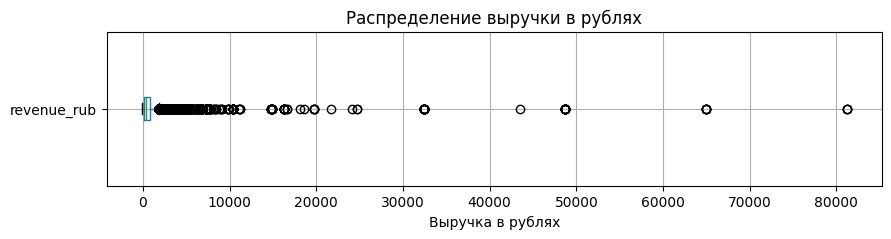

In [ ]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 2))

# Строим диаграмму размаха значений в столбце balance
df.boxplot(column='revenue_rub', vert=False) # учитывая разброс - логично сделать горизонтально

# Добавляем заголовок и метки оси
plt.title('Распределение выручки в рублях')
plt.xlabel('Выручка в рублях')

# Выводим график
plt.show()

Выбросов достаточно много. 81к - самый большой. В диапазоне от 10к до 81к их около 20-30 штук.

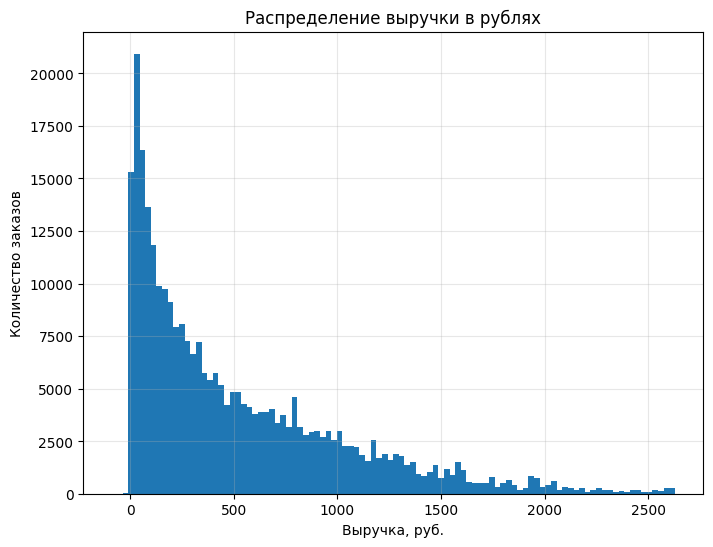

In [ ]:
'''Фильтруем по 99 процентилю'''
p99 = df['revenue_rub'].quantile(0.99) # находим 99 процентиль
df = df[df['revenue_rub'] <= p99]
'''Строим распределение'''
plt.figure(figsize=(8, 6))
plt.hist(df['revenue_rub'], bins=100)
plt.title('Распределение выручки в рублях')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество заказов')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
removed_rows = len(df_original) - len(df)
print("Удалено записей:", removed_rows)
print("Удалено записей в %:", round(removed_rows * 100 / len(df_original), 2))

Удалено записей: 2825
Удалено записей в %: 0.97


Удалено менее 1% записей

По выручке (поле `revenue_rub`) получаем большой выброс в большую сторону, поэтому при построении диаграммы отфильтровываем его. Диаграмма смещена вправо, имеет длинный правый хвост. Это означает, что в данных есть редкие заказы с высокой стоимостью. Возможно, это вип места(или какая то высокая категория, которую мало кто может позволить. А может быть ошибка ввода данных(например неправильно вбили валюту)) 

По количеству билетов (поле `tickets_count`). Распределение также имеет правый хвост из-за выбросов. Медиана 3, Среднее значение 2,75. Большинство заказов в диапазоне 1-3 билета. Покупка одного билета - самый частый сценарий в плане досуга. 57 билетов(максимальное значение) - похоже на выброс(это или ошибка, или кто то заказывал билеты на группу людей - например школьный класс). Стандартное отклонение 1,17 - в целом небольшое, подверждает, что большая часть билетов внутри диапазона  1-3 .

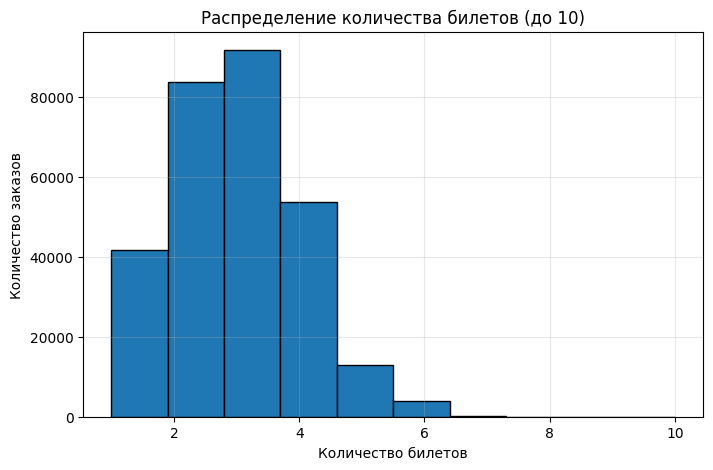

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df[df['tickets_count'] <= 10]['tickets_count'], bins=10, edgecolor='black')
plt.title('Распределение количества билетов (до 10)')
plt.xlabel('Количество билетов')
plt.ylabel('Количество заказов')
plt.grid(alpha=0.3)
plt.show()

#### Промежуточный вывод после предобработки
<font color='#00000cff'><br>
    1. Сформулированы цели проекта и поставлены задачи;<br>
    2. Проведено описание даных и составлено содержание проекта;<br>
    3. Выполненно знакомство с датасетом: <br>
        - Датасет содержит `290611` строк и `15` столбцов;<br>
        - Типы данных корректные на первый взгляд(поле `ticket_count` скорректировано по типу в int8);<br>
        - Пропуски присутствуют только в поле `days_since_prev`, у пользователей, которые сделали только один заказ. Количество этих пользователей `21933`;<br>
    4. Около 2 % пользователей расчитывались в валюте казахстанский тенге. Сформированно новое поле  `revenue_rub`, где выполнен пересчет значений выручки в валюту: рубли.<br>
    5. Проанализированы столбца :Выбросов достаточно много. `81к` - самый большой. В диапазоне от `10к до 81к их около 20-30 штук`. Построена диаграмма размаха для оценки выбросов. <br>
    6. Данные отфильтрованы по 99 процентилю(отфильтровано `0,97 % записей - 2825 строк`).
    7. Построенны гистограмы для оценки распределения выручки `revenue_rub` и количества билетов `tickets_count`.<br>
    8. Выведена статистика по стобцам ыручки `revenue_rub` и количества билетов `tickets_count`.<br>
</font>

## 2. Шаг 3. Создание профиля пользователя
---

Задачи 3.1 Построение профиля пользователя

In [ ]:
'''Сделаем сортировку по пользователю и времени заказа'''
df = df.sort_values(by=['user_id', 'order_ts'])
df.head(20) # посмотрим, что получилось

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,за билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,билеты без проблем,Озернинский край,Родниковецк,1390.41
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19.0,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,облачко,Лугоградская область,Кристалевск,902.74
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,край билетов,Каменевский регион,Глиногорск,917.83
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,лучшие билеты,Поленовский край,Дальнозолотск,47.78
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16.0,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,лучшие билеты,Поленовский край,Дальнозолотск,74.84
16,000cf0659a9f40f,mobile,6818017,2024-06-20,2024-06-20 10:35:26,rub,1421.91,4,0.0,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,лови билет!,Широковская область,Радужнополье,1421.91


In [ ]:
'''Ищем дату первого и последнего заказа и некоторые дополнительные признаки по брифу'''
user_profile = df.groupby('user_id', as_index=False).agg(
    first_order_dt=('order_dt', 'min'), # дата первого заказа
    last_order_dt=('order_dt', 'max'), # дата последнего заказа
    total_orders=('order_id', 'count'), # общее количество заказов
    avg_revenue_rub=('revenue_rub', 'mean'), # средняя выручка с заказа
    avg_tickets=('tickets_count', 'mean'), # среднее количество билетов в заказе
    avg_days_between=('days_since_prev', 'mean') # среднее время между заказами
)
user_profile

,user_id,first_order_dt,last_order_dt,total_orders,avg_revenue_rub,avg_tickets,avg_days_between
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.000
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.000
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.000
...,...,...,...,...,...,...,...
21849,fff13b79bd47d7c,2024-07-16,2024-10-31,9,688.043333,2.555556,13.375
21850,fff32fc9ad0f9f6,2024-08-15,2024-10-28,2,850.995000,2.500000,74.000
21851,fffcd3dde79eb2c,2024-06-20,2024-10-30,33,557.908485,2.787879,4.125
21852,fffeeb3c120cf0b,2024-09-24,2024-09-24,1,661.530000,2.000000,NaN


In [ ]:
first_order = df.groupby('user_id', as_index=False).first() # берем только первую строку для каждого пользователя
'''Добавляем признаки'''
user_profile['first_device'] = first_order['device_type_canonical'] # устройство для первого заказа
user_profile['first_region'] = first_order['region_name'] # регион первого заказа
user_profile['first_service'] =first_order['service_name'] # оператор первого заказа
user_profile['first_event_type']= first_order['event_type_main'] # событие в первом заказе
user_profile['is_two'] = (user_profile['total_orders']>=2).astype(int) # бинарный признак 2 и более заказов
user_profile['is_five']  = (user_profile['total_orders']>=5).astype(int)
user_profile

,user_id,first_order_dt,last_order_dt,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,first_device,first_region,first_service,first_event_type,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.940000,4.000000,NaN,mobile,Каменевский регион,край билетов,театр,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.010000,3.000000,75.000,mobile,Каменевский регион,мой билет,выставки,1,0
2,000898990054619,2024-07-13,2024-10-23,3,767.213333,2.666667,51.000,mobile,Североярская область,лови билет!,другое,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.830000,4.000000,NaN,desktop,Каменевский регион,край билетов,театр,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.310000,1.500000,16.000,mobile,Поленовский край,лучшие билеты,театр,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21849,fff13b79bd47d7c,2024-07-16,2024-10-31,9,688.043333,2.555556,13.375,mobile,Каменевский регион,мой билет,другое,1,1
21850,fff32fc9ad0f9f6,2024-08-15,2024-10-28,2,850.995000,2.500000,74.000,desktop,Каменевский регион,билеты без проблем,стендап,1,0
21851,fffcd3dde79eb2c,2024-06-20,2024-10-30,33,557.908485,2.787879,4.125,desktop,Каменевский регион,билеты без проблем,концерты,1,1
21852,fffeeb3c120cf0b,2024-09-24,2024-09-24,1,661.530000,2.000000,NaN,desktop,Широковская область,билеты без проблем,стендап,0,0


In [ ]:
# Округлим значения некоторых полей
user_profile['avg_revenue_rub'] = user_profile['avg_revenue_rub'].round(2)
user_profile['avg_tickets'] = user_profile['avg_tickets'].round(2)
user_profile['avg_days_between'] = user_profile['avg_days_between'].round(2)
user_profile.head(20) # смотрим, что получилось

,user_id,first_order_dt,last_order_dt,total_orders,avg_revenue_rub,avg_tickets,avg_days_between,first_device,first_region,first_service,first_event_type,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,1,1521.94,4.00,NaN,mobile,Каменевский регион,край билетов,театр,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,2,774.01,3.00,75.00,mobile,Каменевский регион,мой билет,выставки,1,0
2,000898990054619,2024-07-13,2024-10-23,3,767.21,2.67,51.00,mobile,Североярская область,лови билет!,другое,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,1,917.83,4.00,NaN,desktop,Каменевский регион,край билетов,театр,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,2,61.31,1.50,16.00,mobile,Поленовский край,лучшие билеты,театр,1,0
5,000cf0659a9f40f,2024-06-20,2024-06-21,13,1175.81,3.31,0.08,mobile,Широковская область,лови билет!,концерты,1,1
6,00147c9209d45d3,2024-06-25,2024-06-25,2,352.94,1.50,0.00,mobile,Каменевский регион,облачко,концерты,1,0
7,0018ecd8a38a51b,2024-07-25,2024-07-25,1,0.00,3.00,NaN,mobile,Медовская область,билеты без проблем,спорт,0,0
8,00199a573901564,2024-06-17,2024-06-17,1,588.12,4.00,NaN,mobile,Каменевский регион,билеты без проблем,концерты,0,0
9,001e7037d013f0f,2024-07-04,2024-09-29,3,326.62,1.33,43.50,mobile,Златопольский округ,мой билет,другое,1,0


Задача 3.2

In [ ]:
# общее число пользователей
total_users = user_profile.shape[0]
print(f"Общее число пользователей: {total_users}")

Общее число пользователей: 21854


In [ ]:
# средняя выручка с одного заказа(посчитаю двумя способами)
avg_revenue = df['revenue_rub'].mean().round(2)
print(f"Cредняя выручка с одного заказа: {avg_revenue}")
# средняя выручка с заказов среди пользователей
avg_users_revenue = user_profile['avg_revenue_rub'].mean().round(2)
print(f"Cредняя выручка заказов среди пользователей: {avg_revenue}")

Cредняя выручка с одного заказа: 518.03
Cредняя выручка заказов среди пользователей: 518.03


In [ ]:
# доли пользователей совершивших 2 или 5 и более заказов
share_two = user_profile['is_two'].mean().round(2)
share_five = user_profile['is_five'].mean().round(2)
print(f"Доля пользователей с 2 и более заказами: {share_two}")
print(f"Доля пользователей с 5 заказами: {share_five}")


Доля пользователей с 2 и более заказами: 0.62
Доля пользователей с 5 заказами: 0.29


In [ ]:
'''Статистические показатели по общему числу заказов'''
user_profile['total_orders'].describe()

count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: total_orders, dtype: float64

По числу заказов видим, что максимальное значение слишком большое строим диаграмму размаха

<Axes: title={'center': 'Распределение общего количества заказов'}>

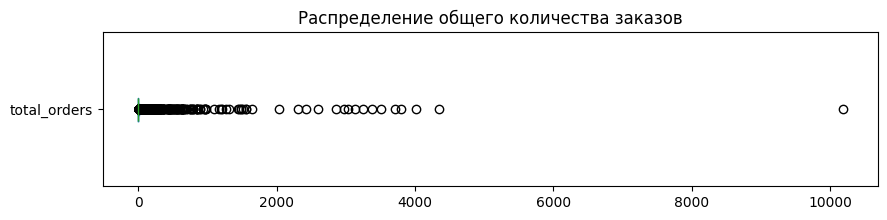

In [ ]:
user_profile['total_orders'].plot(kind='box', figsize=(10, 2), vert=False, title='Распределение общего количества заказов')

По диаграмме размаха видим выбросы. Медиана 2, а максимум 10к - распределение сильно смещено вправо. Стандартное отклонение существенно превышает среднее значение. Стоит отфильтровать по 95 процентилю, так как у одного пользователя не может быть такого количества заказов. Явная ошибка(либо за пользователем скрывается сайт-агрегатор-перекуп).

In [ ]:
'''Перед фильтрованием зафиксируем изначальный датафрейм'''
user_profile_original = user_profile.copy()
profile_row_size = len(user_profile_original) # размер изначального для последующего контроля
profile_row_size

21854

In [ ]:
'''Фильтруем по 95 процентилю'''
p95_orders = user_profile['total_orders'].quantile(0.95) # находим 95 процентиль
user_profile_95 = user_profile[user_profile['total_orders'] <= p95_orders]
user_profile_95['total_orders'].describe()

count    20761.000000
mean         4.049564
std          5.113359
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         31.000000
Name: total_orders, dtype: float64

<Axes: title={'center': 'Распределение общего количества заказов(после 95% фильтра)'}>

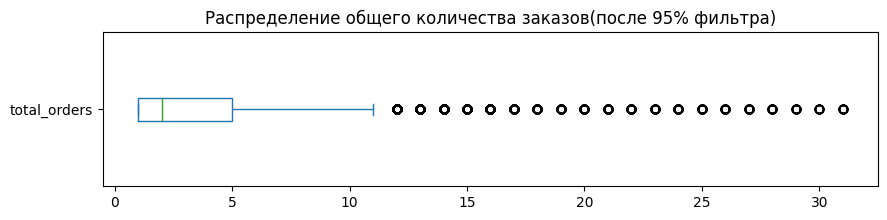

In [ ]:
user_profile_95['total_orders'].plot(kind='box', figsize=(10, 2), vert=False, title='Распределение общего количества заказов(после 95% фильтра)')

Согласно диаграмме размаха, выбросы остались. Но количество этих выбросов меньше, а их значения близки к адекватным(максимальный равен 31 - это мог быть заказ на группу людей). 

In [ ]:
'''Статистические показатели по среднему числу билетов в заказе'''
user_profile_95['avg_tickets'].describe()

count    20761.000000
mean         2.743603
std          0.934549
min          1.000000
25%          2.000000
50%          2.750000
75%          3.150000
max         11.000000
Name: avg_tickets, dtype: float64

По количеству билетов статичтика выглядит нормальной. Среднее 2.7 - адекватное значение. Максимальное - 11 билетов - это может быть семья или большая компания друзей или класс. Считаю, что по этому полю не стоит ничего менять.

In [ ]:
'''Статистические показатели по среднему количеству дней между покупками'''
user_profile_95['avg_days_between'].describe()

count    12420.000000
mean        17.056076
std         22.875066
min          0.000000
25%          1.000000
50%          9.465000
75%         22.170000
max        148.000000
Name: avg_days_between, dtype: float64

В статистике по полю avg_days_between на первый взгляд выглядит подозрительным максимальное значение 148 дней. Но так как датасет покрывает 5 месяцев - это реальная цифра, поэтому здесь тоже нет необходимости в фильтрование. По остальным показателям данная статистика вполне нормальная.

In [ ]:
'''Посчитаем количество отфильтрованных строк'''
removed_rows = len(user_profile_original) - len(user_profile_95)
print("Удалено записей:", removed_rows)
print("Удалено записей в %:", round(removed_rows * 100 / len(user_profile_original), 2))

Удалено записей: 1093
Удалено записей в %: 5.0


#### Краткий вывод по созданию профиля пользователя
---

<font color='#000004ff'><b>Выполненно:</b>
1. Построен профиль пользователя согласно заданию. Добавлено два бинарных признака `is_two` и `is_five`.<br>
2. Расчитаны значения:<br>
         - общее количество пользователей в выорке: `21854`
         - средняя выручка: `518.03`
         - доля пользователей по полю `is_two`: `62 %`
         - доля пользователей по полю  `is_five`: `29 %`
3. Изучены описательный статистики. По полю с количеством заказов выявлены выбросы. Максимальное значение - `10к`, что не реалистично.
Отфильтровано только один раз - `5 % строк`(`1093 шт`). Итоговый отфильтрованный датафрейм - `user_profile_95`.
</font><br>



## Шаг 4. Исследовательский анализ данных
---

Задача 4.1.1

Проводим сегментацию по признакам: `'first_event_type', 'first_device', 'first_region', 'first_service'`

Топ-7 сегментов по признаку: first_event_type
Всего сегментов: 7
                  Количество  Доля, %
first_event_type                     
концерты                9643    44.12
другое                  5490    25.12
театр                   4289    19.63
стендап                 1118     5.12
спорт                    801     3.67
выставки                 418     1.91
ёлки                      95     0.43
Топ-2 сегментов по признаку: first_device
Всего сегментов: 2
              Количество  Доля, %
first_device                     
mobile             18108    82.86
desktop             3746    17.14
Топ-10 сегментов по признаку: first_region
Всего сегментов: 81
                      Количество  Доля, %
first_region                             
Каменевский регион          7159    32.76
Североярская область        3799    17.38
Широковская область         1237     5.66
Озернинский край             678     3.10
Малиновоярский округ         529     2.42
Шанырский регион             503     2.

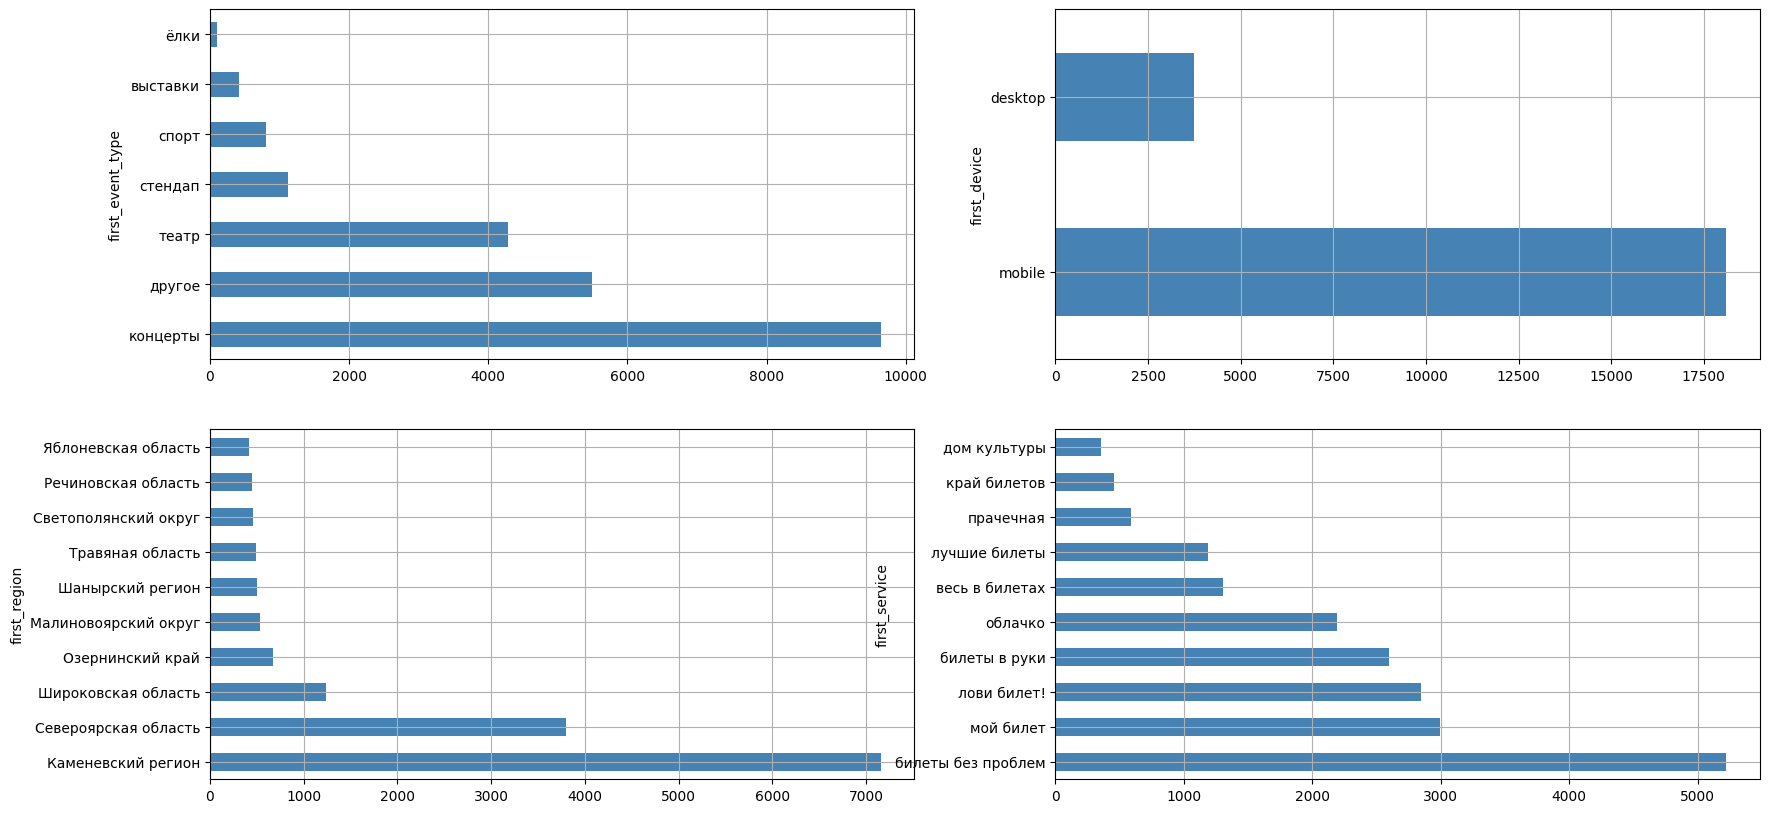

In [ ]:

list_features = ['first_event_type', 'first_device', 'first_region', 'first_service']

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(list_features):
    type_first_feature = user_profile[feature].value_counts() # подсчет количества пользователей по сегментам
    total = type_first_feature.sum() #общее количество пользователей
    '''Так как есть признаки, содержащие большое количество сегментов, выведем топ 10, это позволит выявить самые много численные'''
    top_counts = type_first_feature.head(10) # количество в топ 10
    top_percent = (top_counts / total *100).round(2) # доли в топ 10
       
    total_df = pd.DataFrame({
        'Количество': top_counts,
        'Доля, %': top_percent
    })
    # выводим расчет количества и доли по сегменту
    print(f"Топ-{len(top_counts)} сегментов по признаку: {feature}")
    print(f"Всего сегментов: {len(type_first_feature)}")
    print(total_df)
    top_counts.plot( # строим столбчатую диаграмму
        kind='barh',
        ax=axes[i],
        color='steelblue',
    )
    axes[i].grid()
plt.show()


<font color='black'>Данные по каждому из признаков НЕ распределены равномерно и можно явно выделить лидеров. 
 - концерты - лидер по тпиу события: Количество пользователей: `9643` Доля `44.12  %`; (сегменты 'другое' и 'театра' по `25%` и `19%` соответственно)
 - по типу устройства лидер - мобильный телефон - почти `83 %` пользователей;
 - По региону Каменевский регион — `32,8%` пользователей, на втром месте Североярская область - `17,4 % `. Всего регионов `81`, а эти два - уже составляют половину пользователей;
 -  по билетному оператору:<br>
        - 'билеты без проблем' 5223    Доля: 23.90 %<br>
        - 'мой билет'          2992    Доля: 13.69 %<br>
        - 'лови билет!'        2848    Доля: 13.03 %<br>
        - 'билеты в руки'      2594    Доля: 11.87 %<br>
        - 'облачко'            2194    Доля: 10.04 %<br>
в сумме эти сервисы покрывают около `73 %` пользователей.</font>

Задача 4.1.2

Топ-7 сегментов по признаку: first_event_type
                  Всего пользователей  Вернулись(is_two)  \
first_event_type                                           
концерты                         9643               5994   
другое                           5490               3299   
театр                            4289               2737   
стендап                          1118                684   
спорт                             801                450   
выставки                          418                269   
ёлки                               95                 53   

                  Доля возвратившихся, %  
first_event_type                          
концерты                           62.16  
другое                             60.09  
театр                              63.81  
стендап                            61.18  
спорт                              56.18  
выставки                           64.35  
ёлки                               55.79  
Топ-2 сегментов по признак

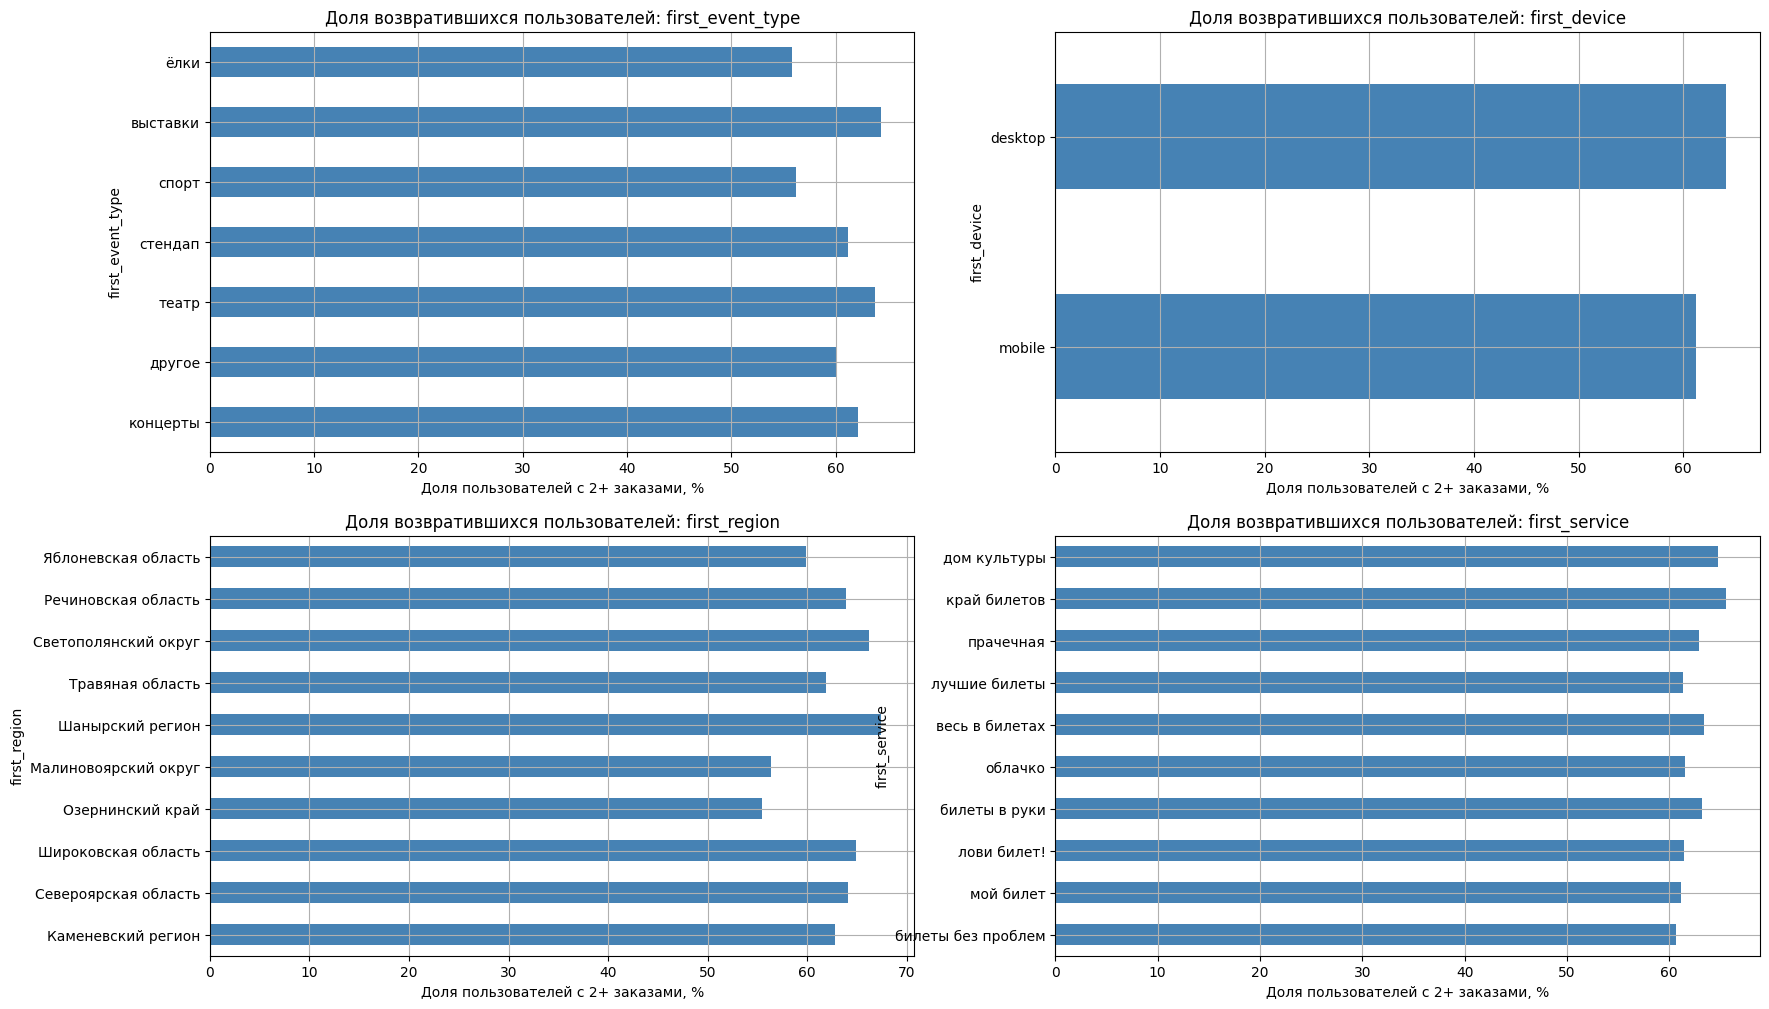

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, feature in enumerate(list_features):
    total_per_segment = user_profile[feature].value_counts() # общее количество пользователей в каждом сегменте
    type_first_feature_is_two = user_profile[user_profile['is_two']==1][feature].value_counts() # подсчет количества пользователей по сегментам

    '''Так как есть признаки, содержащие большое количество сегментов, выведем топ 10, это позволит выявить самые много численные'''
    
    total_df_is_two = pd.DataFrame({
        'total': total_per_segment, # общее количество пользователей по всем сегментам(расчитали в прошлом задании)
        'returned': type_first_feature_is_two  # количество пользователей, совершивших два и более заказа(вернувшиеся клиенты)
    }).fillna(0)
    # считаем долю вернувшихся пользователей(два и более заказов)
    total_df_is_two['return_rate'] = (total_df_is_two['returned'] / total_df_is_two['total'] *100).round(2)
    
    total_df_is_two = total_df_is_two.sort_values('total', ascending=False)
    top_10 = min(10, len(total_df_is_two)) # берем все, если сегментов меньше 10
    total_df_is_two_top = total_df_is_two.head(top_10)
    
    result_table = total_df_is_two_top[['total', 'returned', 'return_rate']].rename(columns={
        'total': 'Всего пользователей',
        'returned': 'Вернулись(is_two)',
        'return_rate': 'Доля возвратившихся, %'
    })
    print(f"Топ-{top_10} сегментов по признаку: {feature}")
    print(result_table)
    
    total_df_is_two_top['return_rate'].plot(
        kind='barh',
        ax=axes[i],
        color='steelblue'
    )
    axes[i].set_title(f'Доля возвратившихся пользователей: {feature}')
    axes[i].set_xlabel('Доля пользователей с 2+ заказами, %')
    axes[i].grid()
    
plt.show()

Обнаруживается стабльность по всем сегментам. Доля пользователей, которые возвращаются два и более раза одинаковая и не зависит от типа устройств, события, билетного оператора и региона(из топ 10). Эта доля составляет примерно `55-65` процентов. Это говорит о том, что первый заказ — не определяющий фактор лояльности. Вероятно, качество сервиса, удобство платформы, ценовая политика, маркетинг после первого заказа влияют сильнее, чем «точка входа». Особенно на фоне того, что по первому заказу лидеры есть. Это значит, что удержание клиентов достаточно стабильное по каждому из сегментов.

Задача 4.1.3

<font color='black'>Проверяем Гипотезу 1 Пользователи спорта возвращаются чаще, чем концертов<br>
По спорту количество заказов около 4%, при этом удержание около 56 % - это один из самых низких показателей по удержанию, если сравнивать с другими категориями. Ниже только елки. **Гипотеза 1 опровергнута**
</font>

<font color='black'>Проверяем Гипотезу 2. Больше всего посещают мероприятия в регионах Каменевский регион — `32,8%` пользователей, на втром месте Североярская область - `17,4 % ` при этом доля повтроных заказов в этих регионах 63 и 64 процента. По возвратам это примерно средний уровень среди топ 10 регионов. А выше всего по возвратам - Шанырский регион -67 процентов(при этом там мероприятия посещают 2 процента пользователей). **Гипотеза 2 опровергнута**.
</font>

Задача 4.2.1

<Figure size 1200x600 with 0 Axes>

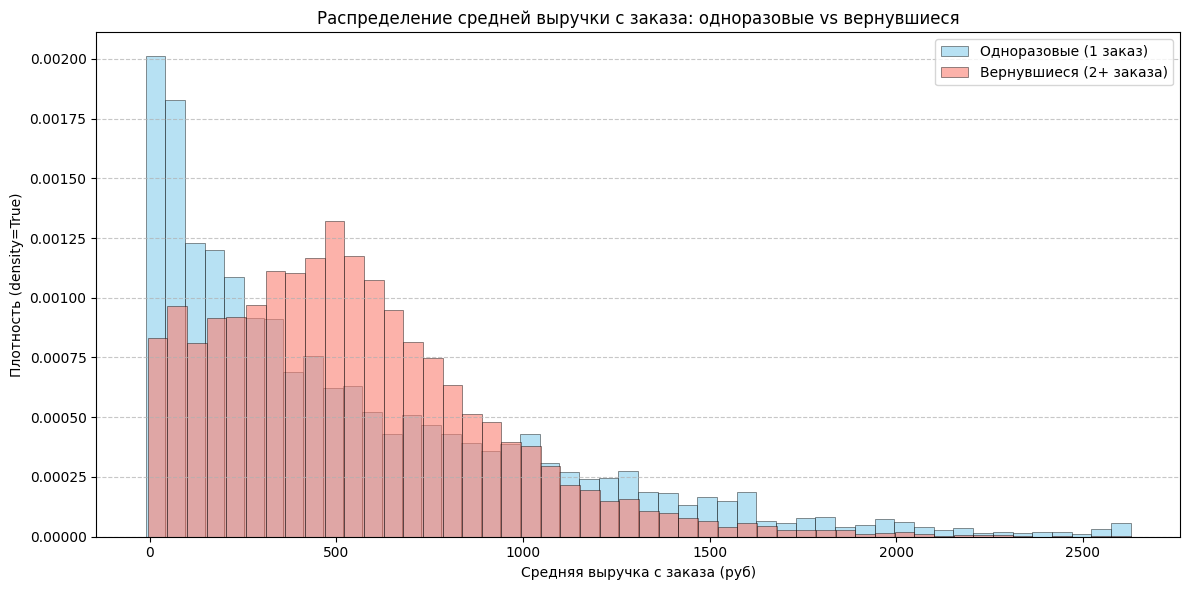

In [ ]:
'''Разделим пользователей на группы'''
one_time = user_profile[user_profile['total_orders'] == 1]['avg_revenue_rub'] # совершившие 1 заказ
returned = user_profile[user_profile['is_two'] == 1]['avg_revenue_rub'] # вернувшиеся (2 и более)

'''Строим гистограммы'''

plt.figure(figsize=(12, 6))
plt.figure(figsize=(12, 6))

plt.hist(one_time, bins=50, 
         alpha=0.6, label='Одноразовые (1 заказ)', 
         density=True, color='skyblue', edgecolor='black', linewidth=0.5)

plt.hist(returned, bins=50, 
         alpha=0.6, label='Вернувшиеся (2+ заказа)', 
         density=True, color='salmon', edgecolor='black', linewidth=0.5)

plt.title('Распределение средней выручки с заказа: одноразовые vs вернувшиеся')
plt.xlabel('Средняя выручка с заказа (руб)')
plt.ylabel('Плотность (density=True)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Распределения различаются. Для одноразовых пользователей средняя выручка с заказа ближе к дешевому диапазону цен 0 - 100 (руб). Возможно это возвраты билетов. А вот для пользователей совершивших 2+ заказа средняя выручка в раоне 500 +- 100 руб. На обеих диаграммых наблюдается длинный хвост в сторону высокой стоимости, т.е доля клиентов совершавших дорогие заказы мала. Средняя выручка оказалась показателем лояльности клиентов.

Задача 4.2.2.


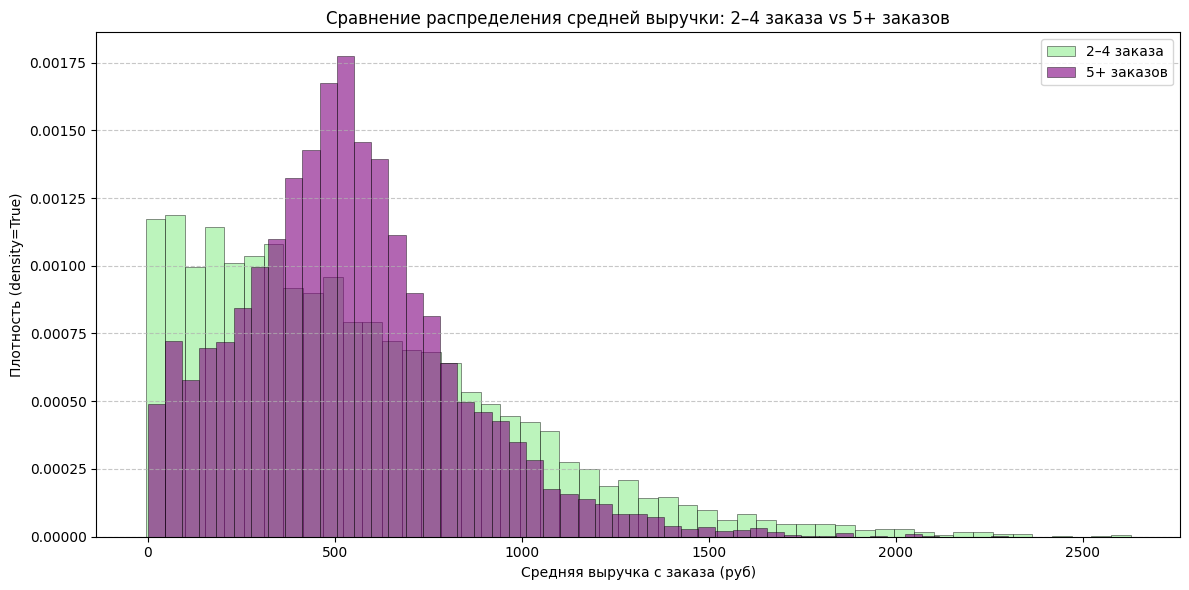

In [ ]:
# Группа 1: 2–4 заказа
group_2_to_4 = user_profile[(user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)]['avg_revenue_rub']

# Группа 2: 5+ заказов
group_5_plus = user_profile[user_profile['is_five'] == 1]['avg_revenue_rub']


bins = 50

plt.figure(figsize=(12, 6))

plt.hist(group_2_to_4, bins=bins,
         alpha=0.6, label='2–4 заказа',
         density=True, color='lightgreen', edgecolor='black', linewidth=0.5)

plt.hist(group_5_plus, bins=bins,
         alpha=0.6, label='5+ заказов',
         density=True, color='purple', edgecolor='black', linewidth=0.5)

plt.title('Сравнение распределения средней выручки: 2–4 заказа vs 5+ заказов')
plt.xlabel('Средняя выручка с заказа (руб)')
plt.ylabel('Плотность (density=True)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
group_2_to_4.describe()

count    7147.000000
mean      551.572374
std       420.197702
min        -5.380000
25%       218.425000
50%       471.270000
75%       798.550000
max      2628.420000
Name: avg_revenue_rub, dtype: float64

In [ ]:
group_5_plus.describe()

count    6339.000000
mean      535.124348
std       294.615106
min         0.000000
25%       336.965000
50%       513.560000
75%       690.015000
max      2299.870000
Name: avg_revenue_rub, dtype: float64

Также наблюдается разница в распределении. Для группы 2-4 заказа среднее 551, а медиана 471, при этом стандартное отклонение 420. Слишком диаграмма смещена влево, большинство значений рассредоточено от 0 до 800 руб выручки.Распределение асимметричное с правым хвостом. Для группы 5 и более заказов среденее и медиана находится примерно на одном уровне 535 и 513. Стандартное распределение при этом меньше. С самых лояльных клиентов средняя выручка около 500+ руб, распределение более симметричное и сосредоточенное.

Задача 4.2.3

Распределение по сегментам среднего числа билетов:
  ticket_segment  total_users  returned_users  return_rate, %
0     1–2 билета         6160            2473           40.15
1     2–3 билета        10144            7589           74.81
2    3–5 билетов         5356            3361           62.75
3     5+ билетов          194              63           32.47


C:\Users\User\AppData\Local\Temp\ipykernel_20452\1726483593.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = user_profile_clean.groupby('ticket_segment').agg(


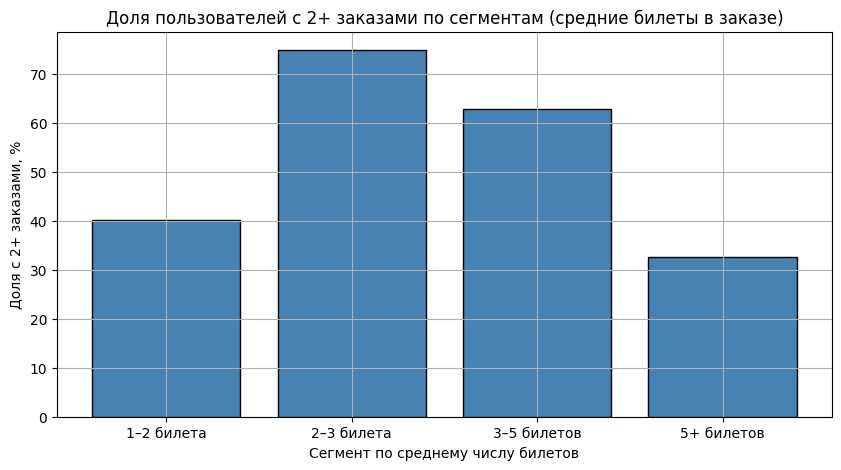

In [ ]:
# Определяем границы сегментов
bins = [1, 2, 3, 5, float('inf')]
labels = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']

# Создаём новый признак — сегмент
user_profile['ticket_segment'] = pd.cut(
    user_profile['avg_tickets'],
    bins=bins,
    labels=labels,
    include_lowest=True  # чтобы включить ровно 1
)

# Удалим возможные NaN
user_profile_clean = user_profile.dropna(subset=['ticket_segment'])

# Агрегация по сегментам
segment_stats = user_profile_clean.groupby('ticket_segment').agg(
    total_users=('user_id', 'size'),
    returned_users=('is_two', 'sum')
).reset_index()

# Считаем долю возвратившихся
segment_stats['return_rate, %'] = (segment_stats['returned_users'] / segment_stats['total_users'] * 100).round(2)

# Выводим таблицу
print("Распределение по сегментам среднего числа билетов:")
print(segment_stats)

# Визуализация: столбчатая диаграмма доли возвратов
plt.figure(figsize=(10, 5))
plt.bar(segment_stats['ticket_segment'], segment_stats['return_rate, %'], color='steelblue', edgecolor='black')
plt.title('Доля пользователей с 2+ заказами по сегментам (средние билеты в заказе)')
plt.xlabel('Сегмент по среднему числу билетов')
plt.ylabel('Доля с 2+ заказами, %')
plt.grid()
plt.show()

Распределение не равномерное. БОльшая доля пользователей с сегменте 2-3 билета - `74 %`. Это самая высокая лояльность. Сегменты 1-2 и 5+ можно сказать близки `40%` и `32 %`. При этом 5+ имеет самую низкую процент вернувшихся - это указывает на низкую лояльность(возможно разовые крупные покупки).

Задача 4.3.1

  first_order_dow_name  total_users  returned_users  return_rate
2                   Пн         2943            1860        63.20
1                   Вт         3189            1979        62.06
5                   Ср         3072            1916        62.37
6                   Чт         3120            1857        59.52
3                   Пт         3261            1952        59.86
4                   Сб         3459            2222        64.24
0                   Вс         2810            1700        60.50


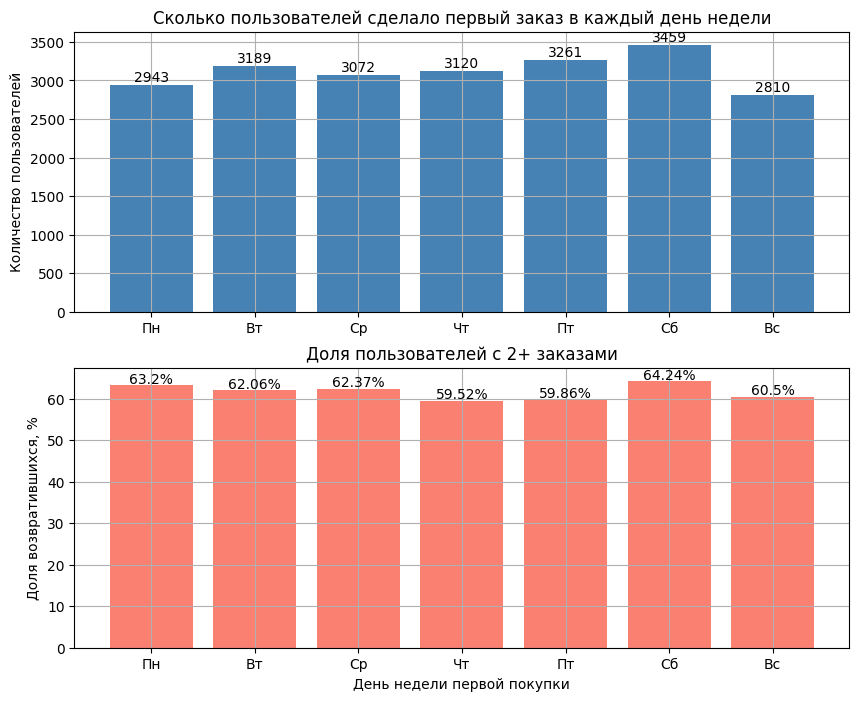

In [ ]:
user_profile['first_order_dow'] = user_profile['first_order_dt'].dt.dayofweek # извлекаем день недели

# для удобства чтения дадим номерам дней названия
dow_names = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
user_profile['first_order_dow_name'] = user_profile['first_order_dow'].map(dow_names)

grouped_dow = user_profile.groupby('first_order_dow_name').agg(
    total_users=('user_id', 'size'),
    returned_users=('is_two', 'sum')
).reset_index()

'''Сортируем по порядку дней недели (Пн → Вс)'''
dow_order = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
grouped_dow['first_order_dow_name'] = pd.Categorical(
    grouped_dow['first_order_dow_name'], 
    categories=dow_order, 
    ordered=True
)
grouped_dow = grouped_dow.sort_values('first_order_dow_name')

grouped_dow['return_rate'] = (grouped_dow['returned_users'] / grouped_dow['total_users'] * 100).round(2) # доля вернувшихся
print(grouped_dow) # печатаем результат

'''Визуализируем'''
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# количество пользователей
ax1.bar(grouped_dow['first_order_dow_name'], grouped_dow['total_users'], color='steelblue')
ax1.set_title('Сколько пользователей сделало первый заказ в каждый день недели')
ax1.set_ylabel('Количество пользователей')
ax1.grid()

# Подписываем значения
for i, v in enumerate(grouped_dow['total_users']):
    ax1.text(i, v + 50, str(v), ha='center')

# доля возвратов
ax2.bar(grouped_dow['first_order_dow_name'], grouped_dow['return_rate'], color='salmon')
ax2.set_title('Доля пользователей с 2+ заказами')
ax2.set_ylabel('Доля возвратившихся, %')
ax2.set_xlabel('День недели первой покупки')
ax2.grid()

# Подписываем %
for i, v in enumerate(grouped_dow['return_rate']):
    ax2.text(i, v + 0.5, f'{v}%', ha='center')

plt.show()


День недели первой покупки практически НЕ влияет на вероятность возврата клиента.<br>
Доля возвратившихся пользователей стабильна во все дни недели — колеблется всего в пределах `59.5%` – `64.2%`, то есть разброс менее 5

Задача 4.3.2

Средний интервал между заказами (дни):
2–4 заказа:
count    7147.000000
mean       21.329937
std        28.484611
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max       148.000000
Name: avg_days_between, dtype: float64
5+ заказов:
count    6339.000000
mean        9.578331
std         7.860181
min         0.000000
25%         3.420000
50%         7.790000
75%        13.780000
max        37.500000
Name: avg_days_between, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_20452\3597798526.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


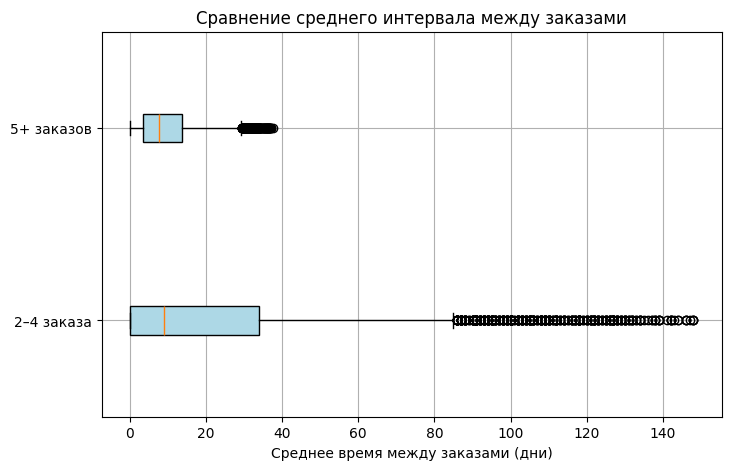

In [ ]:
# Формируем две группы
group_2_to_4 = user_profile[(user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)]
group_5_plus = user_profile[user_profile['is_five'] == 1]

# Печатаем статичтику по ним

print("Средний интервал между заказами (дни):")
print("2–4 заказа:")
print(group_2_to_4['avg_days_between'].describe())
print("5+ заказов:")
print(group_5_plus['avg_days_between'].describe())


# Визуализируем c помощью боксплота
plt.figure(figsize=(8, 5))
plt.boxplot(
    [group_2_to_4['avg_days_between'], 
     group_5_plus['avg_days_between']],
    labels=['2–4 заказа', '5+ заказов'],
    patch_artist=True,
    vert=False,
    boxprops=dict(facecolor='lightblue')
)
plt.title('Сравнение среднего интервала между заказами')
plt.xlabel('Среднее время между заказами (дни)')
plt.grid()
plt.show()

Пользователи с 5+ заказами возвращаются в среднем каждые `9.6` дней, а с 2–4 заказами — каждые `21.3` дня.
У группы 5+ в 2 раза короче интервал между заказами и гораздо меньше разброс (макс. `37.5` дней против `148` дней).
Частые покупки способствуют глубокой лояльности, чем быстрее пользователь возвращается, тем выше шанс, что он останется надолго.

Задача 4.4.1

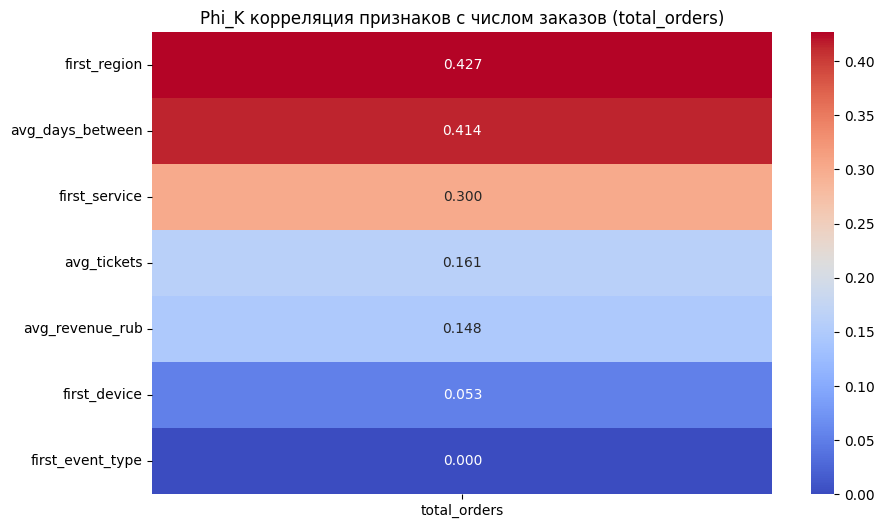

Phi_K корреляция с total_orders:
first_region        0.427
avg_days_between    0.414
first_service       0.300
avg_tickets         0.161
avg_revenue_rub     0.148
first_device        0.053
first_event_type    0.000
Name: total_orders, dtype: float64


In [ ]:
# Числовые признаки:
interval_cols = [
    'avg_revenue_rub',
    'avg_tickets',
    'avg_days_between'
]

# Категориальные:
categorical_cols = [
    'first_event_type',
    'first_device',
    'first_region',
    'first_service'
]
target_col = 'total_orders' # уелевая колонка, по отношению к которой будем вычислять корреляцию
all_cols = categorical_cols + interval_cols + [target_col]
df_corr = user_profile[all_cols].copy() # формируем датафрейм для посчета кор-ии
phik_matrix = df_corr.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 6))
corr_with_target = phik_matrix[target_col].drop(target_col).sort_values(ascending=False)

# Тепловая карта
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt='.3f')
plt.title('Phi_K корреляция признаков с числом заказов (total_orders)')
plt.show()

# 4. Выводим значения
print("Phi_K корреляция с total_orders:")
print(corr_with_target.round(3))

Сильнее всего на число заказов влияют:
 - Регион первого заказа (возможно, разная активность, маркетинг, культура потребления) коэфв кор-ий - 0.427,
 - Средний интервал между заказами (частота заказов связана с лояльностью, как уже выяснили раньше), коэфв кор-ий - 0.414.
 - Оператор билетов. Корреляция 0.3 - находится на границе между слабым влиянием и отсуствием влияния. Возможно некоторые операторы более популярны, но в целом людям все равно, где покупать билет, если это официальный оператор.

Корреляция выявляется достаточно четко. Данные в `totla_orders` распределены равномерно. Дальнейшии манипуляции с ним не требуются.

## Шаг 5. Общие выводы и рекомендации
---

### <font color='black'>Информация о данных:
 - Данные пользователей платформы «Яндекс Афиша» были выгружены с помощью sql запроса. И содержали 290611 строк и 15 столбцов. Типы данных корректные. Пропуски присутствуют только в поле `days_since_prev`, у пользователей, которые сделали только один заказ. Количество этих пользователей `21933<br>
 - Перед анализом:
 Были переведены цены из тенге в рубли,
 Удалены выбросы по выручке (0,97% заказов, >99-й перцентиль),
 Отфильтрованы неправдоподобные пользователи с 10 000+ заказов (5%),
 Сформирован профиль пользователя с агрегированными метриками: число заказов, средняя выручка, среднее число билетов, интервал между заказами, тип первого заказа и др.
### Основные результаты:
 - `38%` - одноразовые пользователи, `64%` - 2-4 заказа, `29%` - 5+ заказов
 - По полю с количеством заказов выявлены выбросы. Максимальное значение - `10к`, что не реалистично.
Отфильтровано только один раз - `5 % строк`(`1093 шт`). Итоговый отфильтрованный датафрейм - `user_profile_95`
 - Данные по каждому из признаков(дата первого заказа, устройство первого заказа, регион, билетный оператор) НЕ распределены равномерно и можно явно выделить лидеров. 
 - концерты - лидер по тпиу события: Количество пользователей: `9643` Доля `44.12  %`; (сегменты 'другое' и 'театра' по `25%` и `19%` соответственно)
 - по типу устройства лидер - мобильный телефон - почти `83 %` пользователей;
 - По региону Каменевский регион — `32,8%` пользователей, на втром месте Североярская область - `17,4 % `. Всего регионов `81`, а эти два - уже составляют половину пользователей;
 -  по билетному оператору:<br>
        - 'билеты без проблем' 5223    Доля: 23.90 %<br>
        - 'мой билет'          2992    Доля: 13.69 %<br>
        - 'лови билет!'        2848    Доля: 13.03 %<br>
        - 'билеты в руки'      2594    Доля: 11.87 %<br>
        - 'облачко'            2194    Доля: 10.04 %<br>
в сумме эти сервисы покрывают около `73 %` пользователей.
- При этом лояльность клиентов равномерна по всем сегментам каждого из признаков и составляет `55-65 %` возвратов на платформу.
- По выручке для одноразовых пользователей средняя выручка с заказа ближе к дешевому диапазону цен 0 - 100 (руб). Возможно это возвраты билетов. А вот для пользователей совершивших 2+ заказа средняя выручка в раоне 500 +- 100 руб. На обеих диаграммых наблюдается длинный хвост в сторону высокой стоимости, т.е доля клиентов совершавших дорогие заказы мала. Средняя выручка оказалась показателем лояльности клиентов.
- По вырочке сегментов для группы 2-4 заказа среднее `551`, а медиана `471`, при этом стандартное отклонение `420`. Слишком диаграмма смещена влево, большинство значений рассредоточено от 0 до 800 руб выручки.Распределение асимметричное с правым хвостом. Для группы 5 и более заказов среденее и медиана находится примерно на одном уровне `535` и `513`. Стандартное распределение при этом меньше. С самых лояльных клиентов средняя выручка около 500+ руб, распределение более симметричное и сосредоточенное.
- По среднему числу билетов БОльшая доля пользователей с сегменте 2-3 билета - `74 %`. Это самая высокая лояльность. Сегменты 1-2 и 5+ можно сказать близки `40%` и `32 %`. При этом 5+ имеет самую низкую процент вернувшихся - это указывает на низкую лояльность(возможно разовые крупные покупки).
- По дню недели: практически НЕ влияет на вероятность возврата клиента.<br>
Доля возвратившихся пользователей стабильна во все дни недели — колеблется всего в пределах `59.5%` – `64.2%`, то есть разброс менее 5
 - Корреляционный анализ: Сильнее всего на число заказов влияют:
    - Регион первого заказа (возможно, разная активность, маркетинг, культура потребления) коэфв кор-ий - 0.427,
    - Средний интервал между заказами (частота заказов связана с лояльностью, как уже выяснили раньше), коэфв кор-ий - 0.414.
    - Оператор билетов. Корреляция 0.3 - находится на границе между слабым влиянием и отсуствием влияния. Возможно некоторые операторы более популярны, но в целом людям все равно, где покупать билет, если это официальный оператор.
### Основные рекомендации:
 <br>-> Фокус на ускорении повторной покупки:
 Запускайте персонализированные рекомендации и скидки в течение первой недели после первого заказа — это критически повышает шансы на лояльность.
 <br>-> Нужно работать с сегментом «1 билет»:
 Это низколояльная группа (40% возвратов). Предлагайте «приведи друга» или дуэты («купите два билета — получите скидку»), чтобы перевести их в зону 2–3 билетов.
 <br>-> Не нужно тратить ресурсы на удержание «5+ билетов»:
 Эти пользователи - разовые организаторы (школы, корпоративы).
 <br>-> Нужно усилить локальный маркетинг в ключевых регионах:
 Несмотря на высокую долю входа, Каменевский и Североярский регионы - не лидеры по удержанию. Изучите практики Шанырского региона (67% возвратов при меньшем трафике).
 <br>-> Нужно упростить выбор билетного оператора:
 Разница между операторами минимальна — пользователей интересует мероприятие, а не сервис.
</font>